<a href="https://colab.research.google.com/github/wendycataldo/A_dissertacao/blob/main/Analise_llm_cruzados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cabeçalho



In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu, f_oneway
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from google.colab import drive

In [25]:
# Montar o Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Caminho do arquivo no Google Drive
caminho_avaliacoes = '/content/drive/MyDrive/Analises dados dis/Analise-cruzada-llm.xlsx'

df = pd.read_excel(caminho_avaliacoes, sheet_name='Avaliacoes_Automaticas')

In [29]:
# Padroniza nomes de LLMs (por exemplo, para primeira maiúscula)
for col in ['LLM_Gerador', 'LLM_Avaliador', 'Tipo_Prompt', 'Criterio']:
    df[col] = df[col].astype(str).str.strip().str.capitalize()
df['Criterio'] = df['Criterio'].str.replace('  ', ' ')  # tira espaços duplos
df['Criterio'] = df['Criterio'].str.replace('Capacidade de resposta', 'Capacidade de resposta')

In [30]:
# 3. Informação básica
print('\nLLM_Gerador únicos:', df['LLM_Gerador'].unique())
print('LLM_Avaliador únicos:', df['LLM_Avaliador'].unique())
print('Tipo_Prompt únicos:', df['Tipo_Prompt'].unique())
print('Critérios únicos:', df['Criterio'].unique())


LLM_Gerador únicos: ['Professor' 'Deepseek' 'Mistal' 'Chatgpt']
LLM_Avaliador únicos: ['Chatgpt' 'Mistral' 'Deepseek']
Tipo_Prompt únicos: ['Professor' 'Prompt' 'Meta prompt']
Critérios únicos: ['Cobertura' 'Gramaticalidade' 'Utilidade' 'Relevância'
 'Capacidade de resposta']


#Analises

In [31]:
# Estatística descritiva cruzada por Critério/LlM_Gerador/LLM_Avaliador/Prompt
print('\nMédia e desvio padrão das pontuações:')
print(df.groupby(['Criterio', 'LLM_Gerador', 'LLM_Avaliador', 'Tipo_Prompt'])['Pontuacao'].agg(['mean','std','count']))


Média e desvio padrão das pontuações:
                                                                  mean  \
Criterio               LLM_Gerador LLM_Avaliador Tipo_Prompt             
Capacidade de resposta Chatgpt     Chatgpt       Meta prompt  4.333333   
                                                 Prompt       4.333333   
                                   Deepseek      Meta prompt  4.333333   
                                                 Prompt       4.000000   
                                   Mistral       Meta prompt  4.666667   
...                                                                ...   
Utilidade              Mistal      Mistral       Meta prompt  3.333333   
                                                 Prompt       4.000000   
                       Professor   Chatgpt       Professor    3.000000   
                                   Deepseek      Professor    3.000000   
                                   Mistral       Professor    3.000000   

/tmp/ipython-input-32-1737311305.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


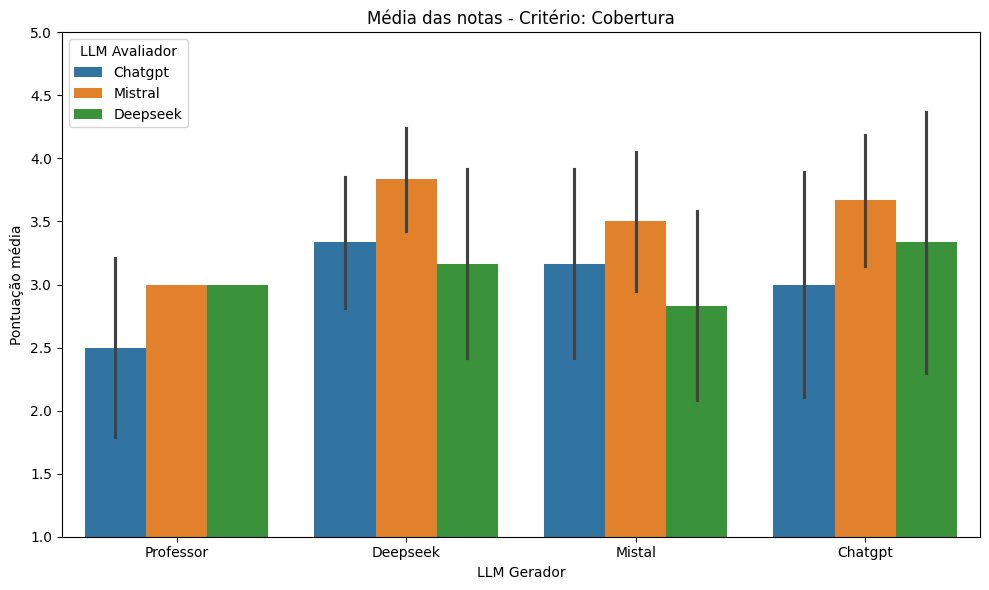

/tmp/ipython-input-32-1737311305.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


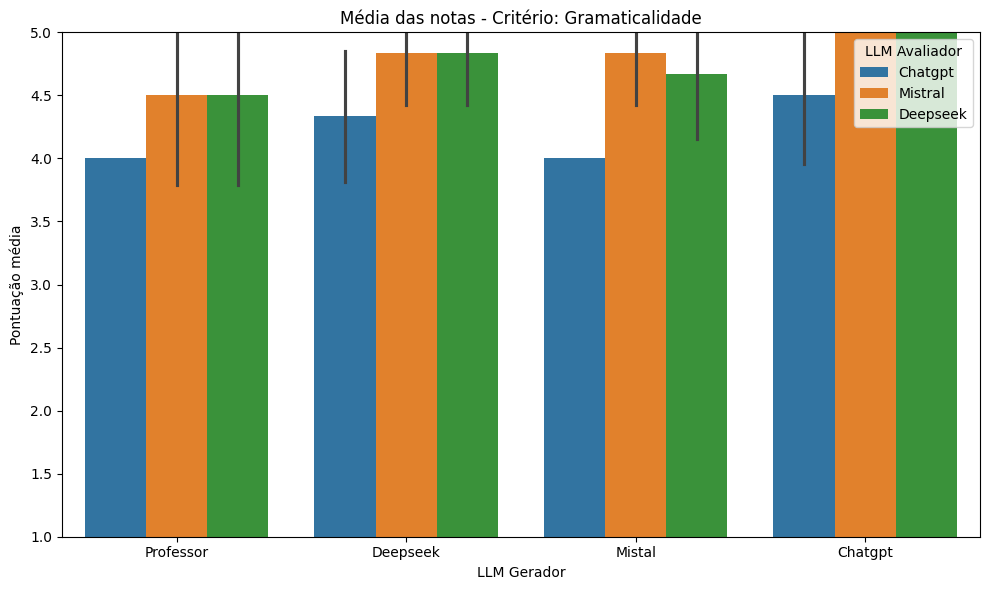

/tmp/ipython-input-32-1737311305.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


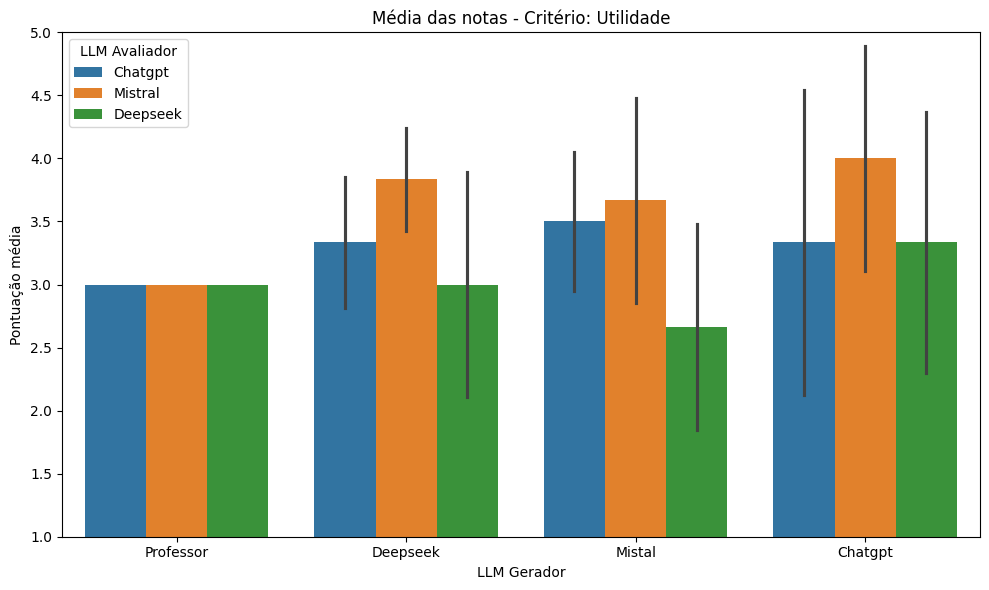

/tmp/ipython-input-32-1737311305.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


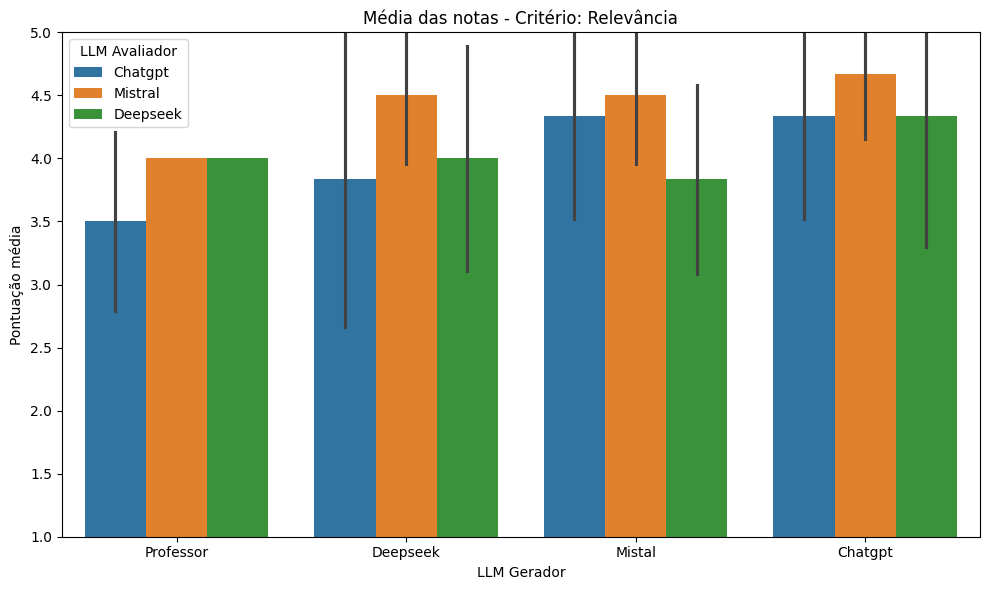

/tmp/ipython-input-32-1737311305.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


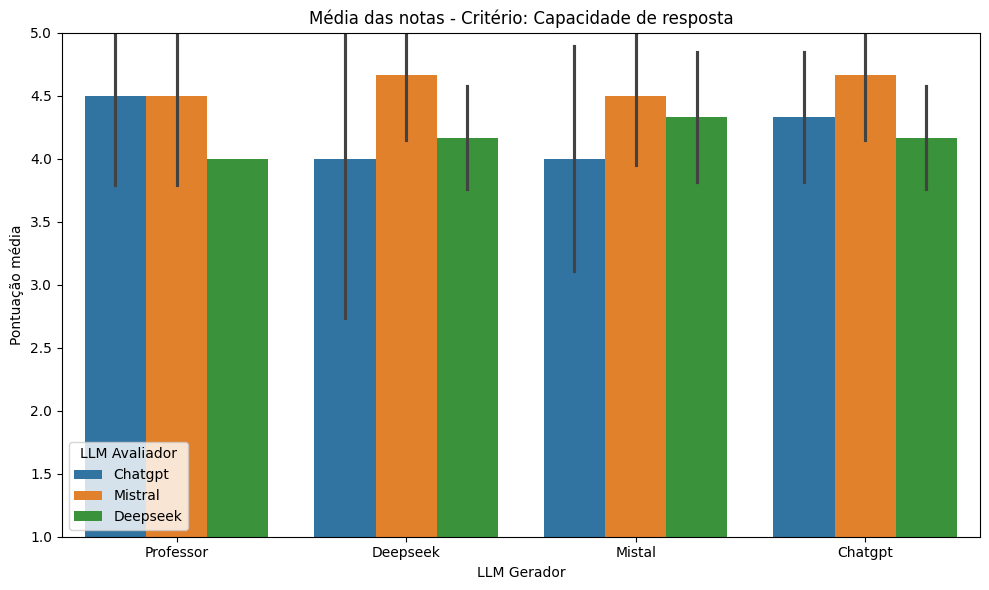

In [32]:
# Gráfico de barras: Média das avaliações por critério (um gráfico por critério)
for crit in df['Criterio'].unique():
    plt.figure(figsize=(10,6))
    plot_df = df[df['Criterio'] == crit]
    sns.barplot(
        data=plot_df,
        x='LLM_Gerador',
        y='Pontuacao',
        hue='LLM_Avaliador',
        ci='sd',
        palette='tab10'
    )
    plt.title(f"Média das notas - Critério: {crit}")
    plt.ylim(1,5)
    plt.ylabel('Pontuação média')
    plt.xlabel('LLM Gerador')
    plt.legend(title='LLM Avaliador')
    plt.tight_layout()
    plt.show()

In [36]:
# ANOVA e post-hoc (Tukey) entre Geradores para cada Avaliador/Critério
for crit in df['Criterio'].unique():
    for avaliador in df['LLM_Avaliador'].unique():
        subdf = df[(df['Criterio']==crit) & (df['LLM_Avaliador']==avaliador)]
        grupos = [g['Pontuacao'] for _, g in subdf.groupby('LLM_Gerador')]
        nomes = list(subdf.groupby('LLM_Gerador').groups.keys())
        if all([len(g)>1 for g in grupos]) and len(grupos) > 1:
            anova = f_oneway(*grupos)
            print(f"\n[ANOVA] Critério: {crit} | Avaliador: {avaliador}")
            print('F = %.3f | p = %.4f' % (anova.statistic, anova.pvalue))
            if anova.pvalue < 0.05:
                resultado_tukey = pairwise_tukeyhsd(subdf['Pontuacao'], subdf['LLM_Gerador'], alpha=0.05)
                print('Teste post-hoc de Tukey:')
                print(resultado_tukey)
        else:
            print(f"[ANOVA] Critério {crit}, Avaliador {avaliador}: grupos insuficientes para ANOVA.")


[ANOVA] Critério: Cobertura | Avaliador: Chatgpt
F = 0.697 | p = 0.5671

[ANOVA] Critério: Cobertura | Avaliador: Mistral
F = 1.648 | p = 0.2179

[ANOVA] Critério: Cobertura | Avaliador: Deepseek
F = 0.388 | p = 0.7633

[ANOVA] Critério: Gramaticalidade | Avaliador: Chatgpt
F = 1.725 | p = 0.2020

[ANOVA] Critério: Gramaticalidade | Avaliador: Mistral
F = 0.944 | p = 0.4428

[ANOVA] Critério: Gramaticalidade | Avaliador: Deepseek
F = 1.067 | p = 0.3909

[ANOVA] Critério: Utilidade | Avaliador: Chatgpt
F = 0.201 | p = 0.8941

[ANOVA] Critério: Utilidade | Avaliador: Mistral
F = 1.034 | p = 0.4041

[ANOVA] Critério: Utilidade | Avaliador: Deepseek
F = 0.561 | p = 0.6482

[ANOVA] Critério: Relevância | Avaliador: Chatgpt
F = 0.686 | p = 0.5737

[ANOVA] Critério: Relevância | Avaliador: Mistral
F = 0.821 | p = 0.5014

[ANOVA] Critério: Relevância | Avaliador: Deepseek
F = 0.343 | p = 0.7943

[ANOVA] Critério: Capacidade de resposta | Avaliador: Chatgpt
F = 0.276 | p = 0.8416

[ANOVA] Crit

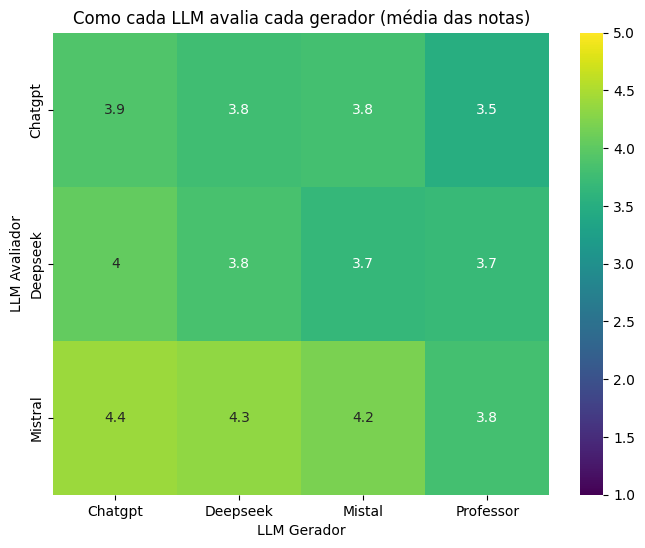

In [37]:
# Heatmap das médias cruzadas: Quem avalia melhor quem?
pivot = df.pivot_table(
    index='LLM_Avaliador', columns='LLM_Gerador', values='Pontuacao', aggfunc='mean'
)
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, vmin=1, vmax=5, cmap='viridis')
plt.title('Como cada LLM avalia cada gerador (média das notas)')
plt.xlabel('LLM Gerador')
plt.ylabel('LLM Avaliador')
plt.show()

In [38]:
# Exportação opcional para uso na redação
df.groupby(['Criterio','LLM_Gerador','LLM_Avaliador'])['Pontuacao'].agg(['mean','std','count']).to_csv('tabela_cruzada_avaliacao.csv')

print('\nPipeline cruzado pronto para análise estatística e visual!')


Pipeline cruzado pronto para análise estatística e visual!


# llm x llm

In [39]:
# Filtrar apenas cruzamentos IA × IA (sem 'Professor' como gerador nem avaliador)
llms_ia = [llm for llm in df['LLM_Gerador'].unique() if llm.lower() != "professor"]
df_cruzado = df[
    (~df['LLM_Gerador'].str.lower().str.contains('professor')) &
    (~df['LLM_Avaliador'].str.lower().str.contains('professor'))
]

print("Incluídos somente cruzamentos entre LLMs. Linhas:", len(df_cruzado))
print('Geradores:', df_cruzado['LLM_Gerador'].unique())
print('Avaliadores:', df_cruzado['LLM_Avaliador'].unique())

Incluídos somente cruzamentos entre LLMs. Linhas: 270
Geradores: ['Deepseek' 'Mistal' 'Chatgpt']
Avaliadores: ['Chatgpt' 'Mistral' 'Deepseek']


In [40]:
# Estatística descritiva cruzada
print('\nMédia e desvio padrão das pontuações (somente LLMS):')
print(df_cruzado.groupby(['Criterio', 'LLM_Gerador', 'LLM_Avaliador', 'Tipo_Prompt'])['Pontuacao'].agg(['mean','std','count']))


Média e desvio padrão das pontuações (somente LLMS):
                                                                  mean  \
Criterio               LLM_Gerador LLM_Avaliador Tipo_Prompt             
Capacidade de resposta Chatgpt     Chatgpt       Meta prompt  4.333333   
                                                 Prompt       4.333333   
                                   Deepseek      Meta prompt  4.333333   
                                                 Prompt       4.000000   
                                   Mistral       Meta prompt  4.666667   
...                                                                ...   
Utilidade              Mistal      Chatgpt       Prompt       3.666667   
                                   Deepseek      Meta prompt  2.666667   
                                                 Prompt       2.666667   
                                   Mistral       Meta prompt  3.333333   
                                                 Prompt   

/tmp/ipython-input-41-102539741.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


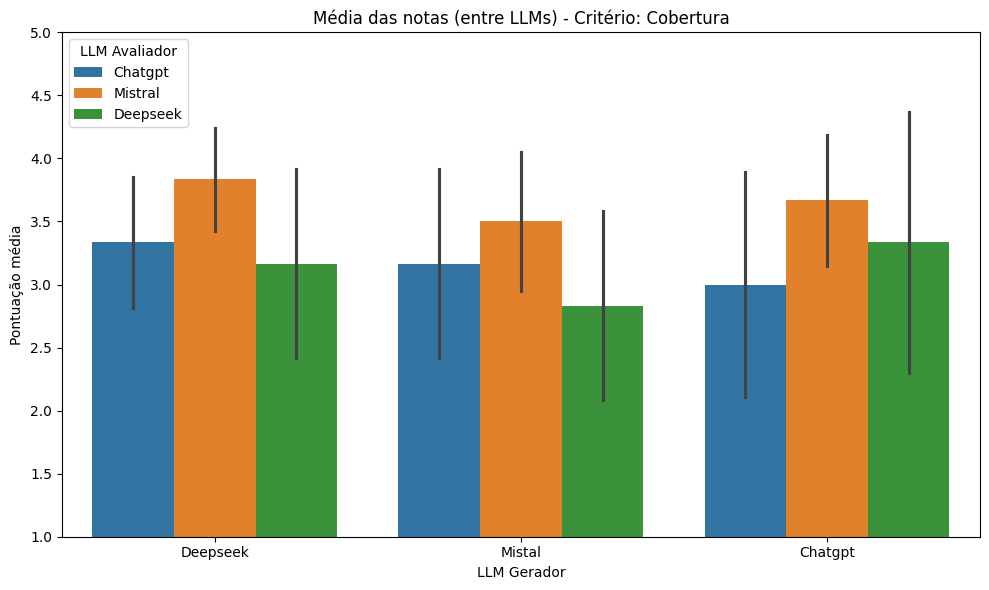

/tmp/ipython-input-41-102539741.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


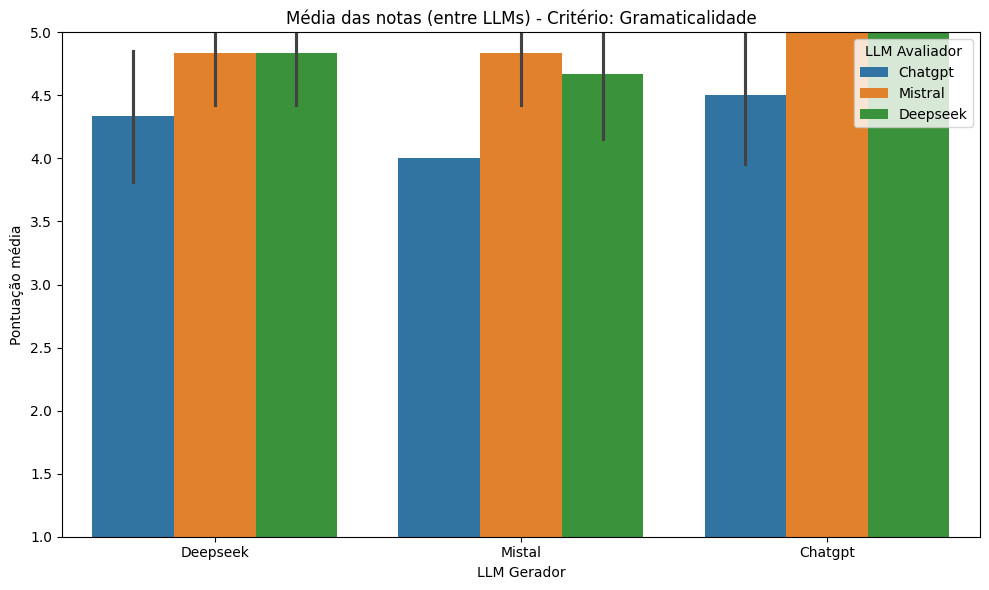

/tmp/ipython-input-41-102539741.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


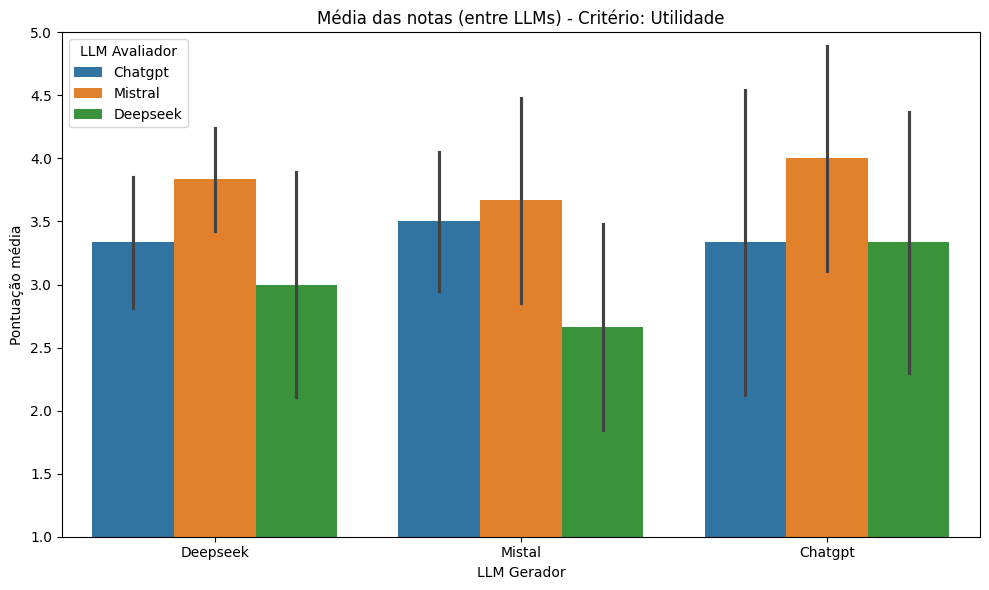

/tmp/ipython-input-41-102539741.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


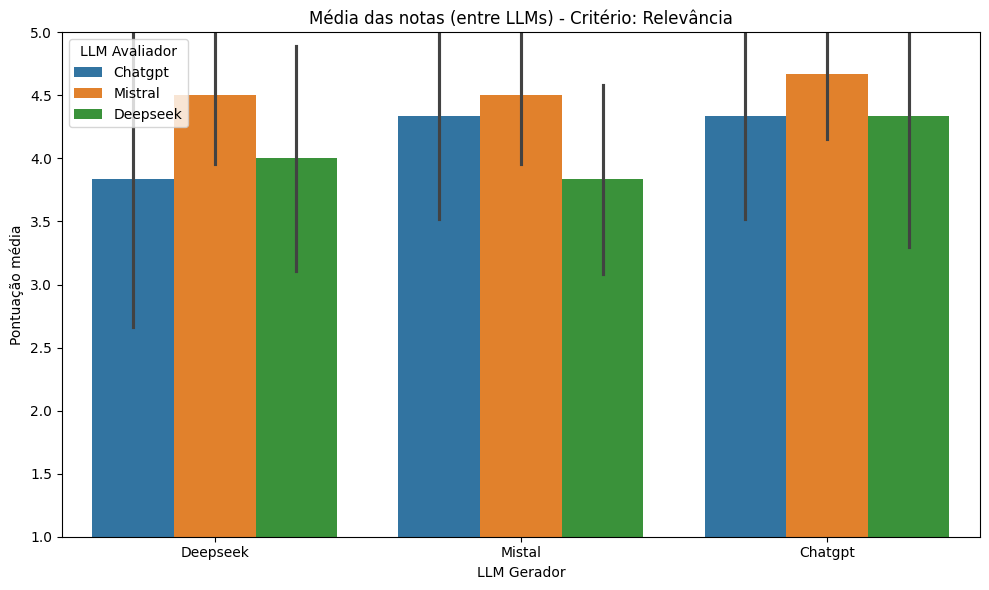

/tmp/ipython-input-41-102539741.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


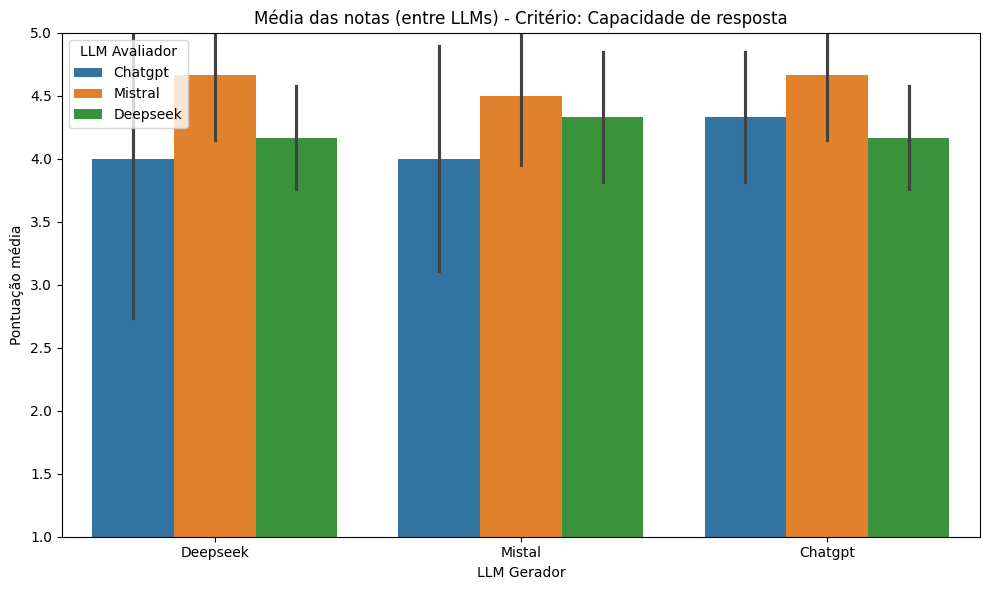

In [41]:
# 5. Gráfico de barras: Média das avaliações por critério (um gráfico por critério)
for crit in df_cruzado['Criterio'].unique():
    plt.figure(figsize=(10,6))
    plot_df = df_cruzado[df_cruzado['Criterio'] == crit]
    sns.barplot(
        data=plot_df,
        x='LLM_Gerador',
        y='Pontuacao',
        hue='LLM_Avaliador',
        ci='sd',
        palette='tab10'
    )
    plt.title(f"Média das notas (entre LLMs) - Critério: {crit}")
    plt.ylim(1,5)
    plt.ylabel('Pontuação média')
    plt.xlabel('LLM Gerador')
    plt.legend(title='LLM Avaliador')
    plt.tight_layout()
    plt.show()

In [ ]:
# ANOVA e post-hoc por Critério / Avaliador (somente entre LLMs)
for crit in df_cruzado['Criterio'].unique():
    for avaliador in df_cruzado['LLM_Avaliador'].unique():
        subdf = df_cruzado[(df_cruzado['Criterio']==crit) & (df_cruzado['LLM_Avaliador']==avaliador)]
        grupos = [g['Pontuacao'] for _, g in subdf.groupby('LLM_Gerador')]
        nomes = list(subdf.groupby('LLM_Gerador').groups.keys())
        if all([len(g)>1 for g in grupos]) and len(grupos) > 1:
            anova = f_oneway(*grupos)
            print(f"\n[ANOVA] Critério: {crit} | Avaliador: {avaliador} (apenas LLMs)")
            print('F = %.3f | p = %.4f' % (anova.statistic, anova.pvalue))
            if anova.pvalue < 0.05:
                resultado_tukey = pairwise_tukeyhsd(subdf['Pontuacao'], subdf['LLM_Gerador'], alpha=0.05)
                print('Teste post-hoc de Tukey:')
                print(resultado_tukey)
        else:
            print(f"[ANOVA] Critério {crit}, Avaliador {avaliador}: grupos insuficientes para ANOVA.")

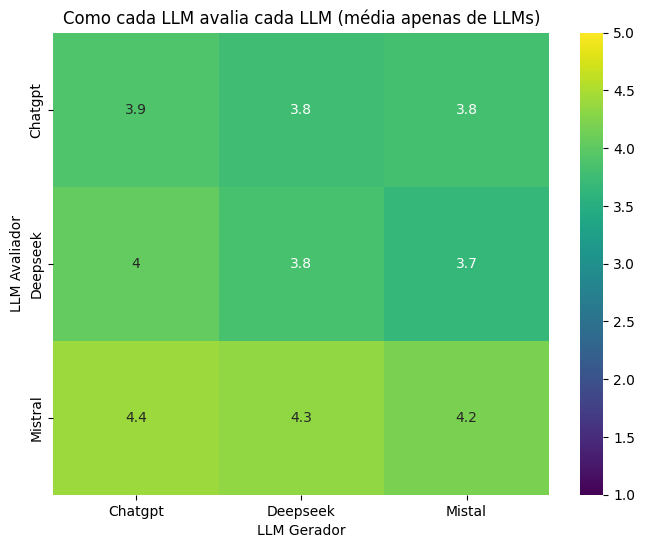

In [42]:
# Heatmap cruzado entre LLMs
pivot = df_cruzado.pivot_table(
    index='LLM_Avaliador', columns='LLM_Gerador', values='Pontuacao', aggfunc='mean'
)
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, vmin=1, vmax=5, cmap='viridis')
plt.title('Como cada LLM avalia cada LLM (média apenas de LLMs)')
plt.xlabel('LLM Gerador')
plt.ylabel('LLM Avaliador')
plt.show()

In [43]:
# Exportação (opcional)
df_cruzado.groupby(['Criterio','LLM_Gerador','LLM_Avaliador'])['Pontuacao'].agg(['mean','std','count']).to_csv('tabela_cruzada_avaliacao_llms.csv')

print('\nPipeline cruzado pronto para análise estatística e visual apenas entre LLMs!')


Pipeline cruzado pronto para análise estatística e visual apenas entre LLMs!


# Outras

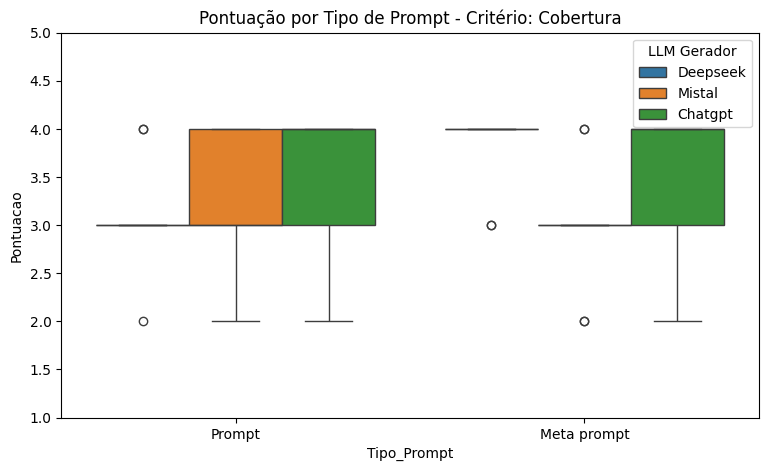

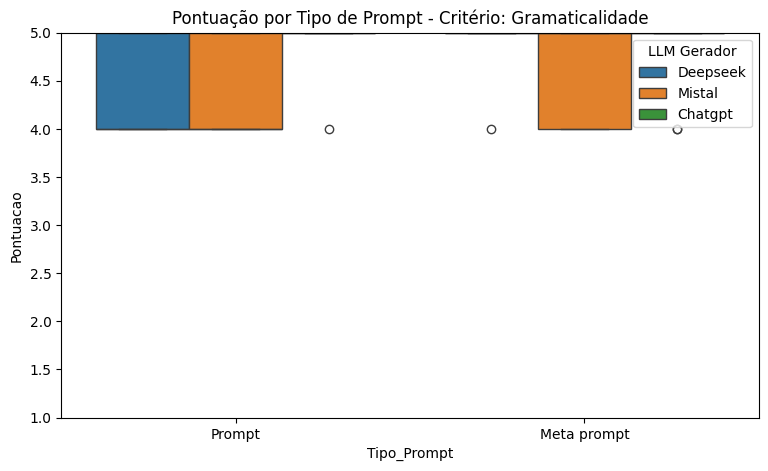

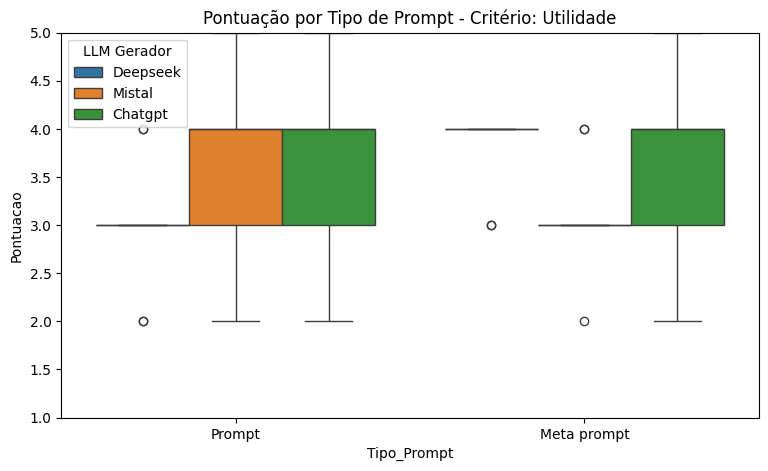

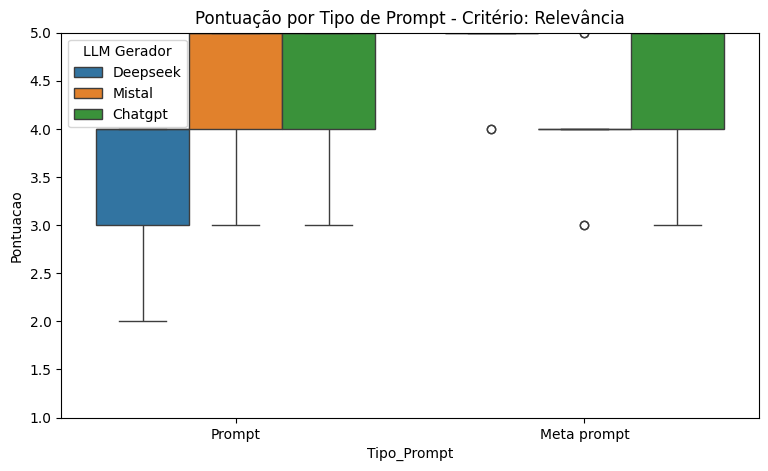

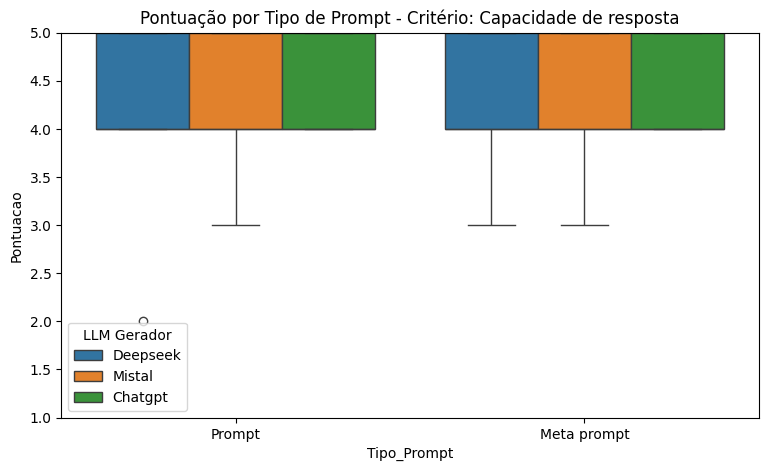

In [46]:
# 1. Comparação entre Tipo de Prompt (“Simples” vs “Meta prompt”)
for crit in df_cruzado['Criterio'].unique():
    plt.figure(figsize=(9,5))
    sns.boxplot(
        data=df_cruzado[df_cruzado['Criterio'] == crit],
        x='Tipo_Prompt',
        y='Pontuacao',
        hue='LLM_Gerador',
        palette='tab10'
    )
    plt.title(f'Pontuação por Tipo de Prompt - Critério: {crit}')
    plt.ylim(1,5)
    plt.legend(title='LLM Gerador')
    plt.show()

In [47]:
# Testes estatísticos por Tipo_Prompt e LLM_Gerador
for crit in df_cruzado['Criterio'].unique():
    for llm in df_cruzado['LLM_Gerador'].unique():
        df_sub = df_cruzado[(df_cruzado['Criterio']==crit) & (df_cruzado['LLM_Gerador']==llm)]
        tipos = df_sub['Tipo_Prompt'].unique()
        if len(tipos) == 2:
            p1 = df_sub[df_sub['Tipo_Prompt']==tipos[0]]['Pontuacao']
            p2 = df_sub[df_sub['Tipo_Prompt']==tipos[1]]['Pontuacao']
            if len(p1) > 1 and len(p2) > 1:
                stat, pval = mannwhitneyu(p1, p2, alternative='two-sided')
                print(f"[{crit}] {llm}, Prompt {tipos[0]} vs {tipos[1]}: U={stat:.2f}, p={pval:.4f}")
        # Se quiser pairwise t-test/ANOVA para mais de 2 grupos, só adaptar

[Cobertura] Deepseek, Prompt Prompt vs Meta prompt: U=17.00, p=0.0223
[Cobertura] Mistal, Prompt Prompt vs Meta prompt: U=51.00, p=0.3341
[Cobertura] Chatgpt, Prompt Prompt vs Meta prompt: U=40.50, p=1.0000
[Gramaticalidade] Deepseek, Prompt Prompt vs Meta prompt: U=22.50, p=0.0588
[Gramaticalidade] Mistal, Prompt Prompt vs Meta prompt: U=36.00, p=0.6838
[Gramaticalidade] Chatgpt, Prompt Prompt vs Meta prompt: U=45.00, p=0.5848
[Utilidade] Deepseek, Prompt Prompt vs Meta prompt: U=16.00, p=0.0191
[Utilidade] Mistal, Prompt Prompt vs Meta prompt: U=50.00, p=0.3950
[Utilidade] Chatgpt, Prompt Prompt vs Meta prompt: U=40.50, p=1.0000
[Relevância] Deepseek, Prompt Prompt vs Meta prompt: U=5.00, p=0.0010
[Relevância] Mistal, Prompt Prompt vs Meta prompt: U=54.50, p=0.1964
[Relevância] Chatgpt, Prompt Prompt vs Meta prompt: U=42.50, p=0.8791
[Capacidade de resposta] Deepseek, Prompt Prompt vs Meta prompt: U=40.00, p=1.0000
[Capacidade de resposta] Mistal, Prompt Prompt vs Meta prompt: U=44.5

In [48]:
# 2. Quem é o avaliador mais rigoroso? (média geral por avaliador)
print('\nMédia geral de pontuação por LLM_Avaliador (quanto menor, mais rigoroso):')
print(df_cruzado.groupby('LLM_Avaliador')['Pontuacao'].mean().sort_values())


Média geral de pontuação por LLM_Avaliador (quanto menor, mais rigoroso):
LLM_Avaliador
Chatgpt     3.822222
Deepseek    3.844444
Mistral     4.311111
Name: Pontuacao, dtype: float64


In [49]:
# 3. Critérios com maior discrepância (desvio padrão por critério)
print('\nDispersão das notas por critério:')
print(df_cruzado.groupby('Criterio')['Pontuacao'].agg(['std','mean','count']))


Dispersão das notas por critério:
                             std      mean  count
Criterio                                         
Capacidade de resposta  0.667976  4.314815     54
Cobertura               0.722263  3.314815     54
Gramaticalidade         0.475831  4.666667     54
Relevância              0.805293  4.259259     54
Utilidade               0.858224  3.407407     54


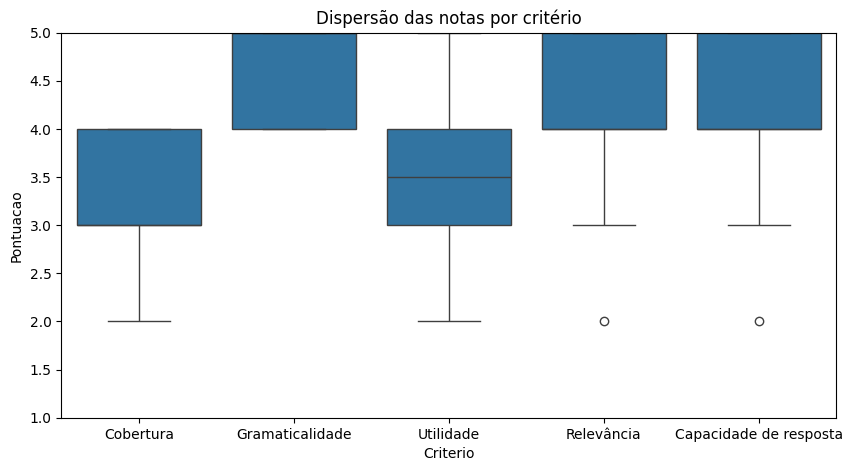

In [50]:
# Boxplot de dispersão para cada critério
plt.figure(figsize=(10,5))
sns.boxplot(data=df_cruzado, x='Criterio', y='Pontuacao')
plt.title('Dispersão das notas por critério')
plt.ylim(1,5)
plt.show()

/tmp/ipython-input-51-1891684477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cruzado['Auto_avalia'] = df_cruzado['LLM_Gerador'] == df_cruzado['LLM_Avaliador']


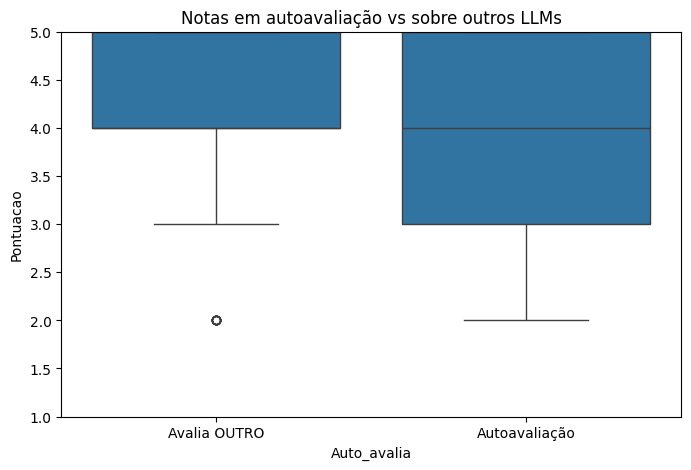


Médias autoavaliação vs outros:
Auto_avalia
False    4.028571
True     3.866667
Name: Pontuacao, dtype: float64


In [51]:
# 4. Mapeamento de reciprocidade (LLM avaliando a si vs. outros)
df_cruzado['Auto_avalia'] = df_cruzado['LLM_Gerador'] == df_cruzado['LLM_Avaliador']
plt.figure(figsize=(8,5))
sns.boxplot(data=df_cruzado, x='Auto_avalia', y='Pontuacao')
plt.xticks([0,1], ['Avalia OUTRO', 'Autoavaliação'])
plt.title('Notas em autoavaliação vs sobre outros LLMs')
plt.ylim(1,5)
plt.show()

print('\nMédias autoavaliação vs outros:')
print(df_cruzado.groupby('Auto_avalia')['Pontuacao'].mean())


Correlação entre critérios:
Criterio                Capacidade de resposta  Cobertura  Gramaticalidade  \
Criterio                                                                     
Capacidade de resposta                1.000000  -0.209302         0.217662   
Cobertura                            -0.209302   1.000000         0.201302   
Gramaticalidade                       0.217662   0.201302         1.000000   
Relevância                           -0.084442   0.830212         0.180546   
Utilidade                            -0.260863   0.884982         0.107807   

Criterio                Relevância  Utilidade  
Criterio                                       
Capacidade de resposta   -0.084442  -0.260863  
Cobertura                 0.830212   0.884982  
Gramaticalidade           0.180546   0.107807  
Relevância                1.000000   0.827102  
Utilidade                 0.827102   1.000000  


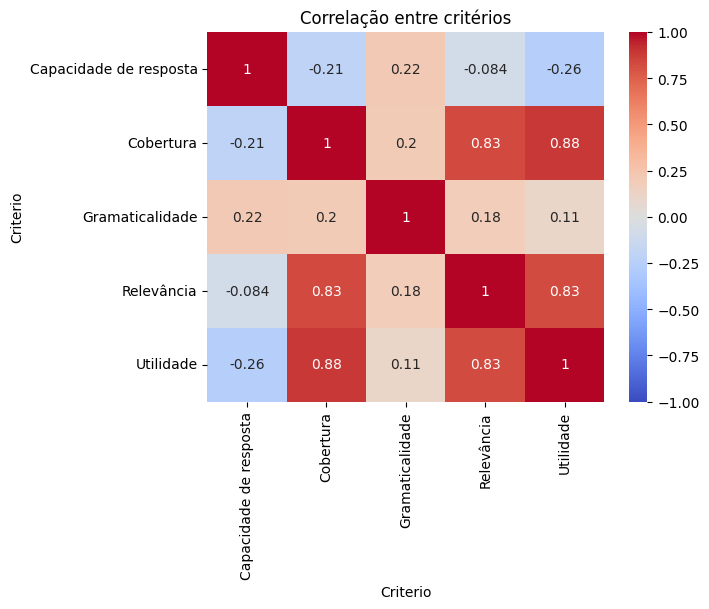

In [52]:
# 5. Correlações entre critérios
pivot = df_cruzado.pivot_table(index=['LLM_Avaliador','LLM_Gerador','ID_Questao'], columns='Criterio', values='Pontuacao', aggfunc='mean')
print('\nCorrelação entre critérios:')
print(pivot.corr())

sns.heatmap(pivot.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlação entre critérios')
plt.show()

In [53]:
# 6. Ranking dos LLMs por critério (quem recebe mais nota, quem menos)
for crit in df_cruzado['Criterio'].unique():
    rank = df_cruzado[df_cruzado['Criterio']==crit].groupby('LLM_Gerador')['Pontuacao'].mean().sort_values(ascending=False)
    print(f"\nRanking por média ({crit}):")
    print(rank)


Ranking por média (Cobertura):
LLM_Gerador
Deepseek    3.444444
Chatgpt     3.333333
Mistal      3.166667
Name: Pontuacao, dtype: float64

Ranking por média (Gramaticalidade):
LLM_Gerador
Chatgpt     4.833333
Deepseek    4.666667
Mistal      4.500000
Name: Pontuacao, dtype: float64

Ranking por média (Utilidade):
LLM_Gerador
Chatgpt     3.555556
Deepseek    3.388889
Mistal      3.277778
Name: Pontuacao, dtype: float64

Ranking por média (Relevância):
LLM_Gerador
Chatgpt     4.444444
Mistal      4.222222
Deepseek    4.111111
Name: Pontuacao, dtype: float64

Ranking por média (Capacidade de resposta):
LLM_Gerador
Chatgpt     4.388889
Deepseek    4.277778
Mistal      4.277778
Name: Pontuacao, dtype: float64


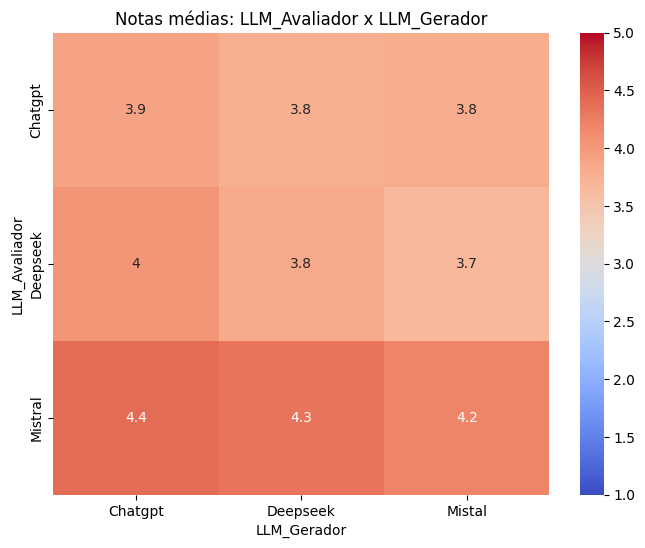

In [54]:
# 7. Matrix de confusão de rigorosidade (diferença média entre LLM_Avaliador x LLM_Gerador)
rigor = df_cruzado.groupby(['LLM_Avaliador', 'LLM_Gerador'])['Pontuacao'].mean().unstack()
plt.figure(figsize=(8,6))
sns.heatmap(rigor, annot=True, cmap='coolwarm', vmin=1, vmax=5)
plt.title('Notas médias: LLM_Avaliador x LLM_Gerador')
plt.show()

In [55]:
# 8. Variação intra-LLM
var_intra = df_cruzado.groupby('LLM_Avaliador')['Pontuacao'].std()
print('\nVariação intra-avaliador:')
print(var_intra)


Variação intra-avaliador:
LLM_Avaliador
Chatgpt     0.881492
Deepseek    0.993361
Mistral     0.697418
Name: Pontuacao, dtype: float64


In [56]:
# 9. Clusterização de padrões de avaliação
# Calcula perfil de cada avaliador (médias por critério e por gerador)
perfil = df_cruzado.pivot_table(
    index='LLM_Avaliador', columns=['LLM_Gerador','Criterio'], values='Pontuacao', aggfunc='mean'
).fillna(df_cruzado['Pontuacao'].mean())
# Normaliza
scaler = StandardScaler()
X = scaler.fit_transform(perfil)
kmeans = KMeans(n_clusters=2, random_state=0)
perfil['cluster'] = kmeans.fit_predict(X)
print('\nClusterização dos avaliadores (grupos de padrões de rigor):')
print(perfil['cluster'])


Clusterização dos avaliadores (grupos de padrões de rigor):
LLM_Avaliador
Chatgpt     0
Deepseek    0
Mistral     1
Name: cluster, dtype: int32


In [57]:
# 10. Outliers/dispersão por LLM_Avaliador x Gerador
# Detecta notas extremas (<2 ou >4.5)
outliers = df_cruzado[(df_cruzado['Pontuacao']<2) | (df_cruzado['Pontuacao']>4.5)]
print('\nCasos extremos (outliers):')
print(outliers[['LLM_Avaliador','LLM_Gerador','Criterio','Tipo_Prompt','Pontuacao']])


Casos extremos (outliers):
    LLM_Avaliador LLM_Gerador                Criterio  Tipo_Prompt  Pontuacao
19        Chatgpt    Deepseek  Capacidade de resposta       Prompt          5
33        Chatgpt      Mistal              Relevância       Prompt          5
38        Mistral      Mistal              Relevância       Prompt          5
44       Deepseek      Mistal  Capacidade de resposta       Prompt          5
46        Chatgpt    Deepseek         Gramaticalidade  Meta prompt          5
..            ...         ...                     ...          ...        ...
291       Mistral     Chatgpt         Gramaticalidade       Prompt          5
292       Mistral     Chatgpt               Utilidade       Prompt          5
293       Mistral     Chatgpt              Relevância       Prompt          5
296      Deepseek     Chatgpt         Gramaticalidade       Prompt          5
298      Deepseek     Chatgpt              Relevância       Prompt          5

[87 rows x 5 columns]


In [58]:
# 11. Comparação detalhada entre todos os pares (testes par-a-par por critério)
for crit in df_cruzado['Criterio'].unique():
    sub = df_cruzado[df_cruzado['Criterio']==crit]
    print(f"\n[Pairwise Tukey] {crit}")
    if sub['LLM_Gerador'].nunique() > 1 and sub['LLM_Avaliador'].nunique() > 1:
        tukey = pairwise_tukeyhsd(sub['Pontuacao'], sub['LLM_Gerador'])
        print(tukey)
    else:
        print('Poucos grupos.')


[Pairwise Tukey] Cobertura
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
 Chatgpt Deepseek   0.1111 0.8908 -0.4738  0.696  False
 Chatgpt   Mistal  -0.1667 0.7716 -0.7515 0.4182  False
Deepseek   Mistal  -0.2778 0.4904 -0.8627 0.3071  False
-------------------------------------------------------

[Pairwise Tukey] Gramaticalidade
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
 Chatgpt Deepseek  -0.1667 0.5328 -0.5404  0.207  False
 Chatgpt   Mistal  -0.3333 0.0893  -0.707 0.0404  False
Deepseek   Mistal  -0.1667 0.5328 -0.5404  0.207  False
-------------------------------------------------------

[Pairwise Tukey] Utilidade
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
--------------